In [113]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample, compute_class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import pickle
import random
import re
import emoji
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
import hashlib
import os
from tqdm import tqdm
import nltk
from nltk.corpus import wordnet
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [114]:
# Ensure NLTK WordNet
try:
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)
    wordnet.synsets('test')
    print("NLTK WordNet loaded successfully")
except Exception as e:
    print(f"Failed to load WordNet: {e}. Using fallback augmentation.")

NLTK WordNet loaded successfully


In [115]:
@tf.keras.utils.register_keras_serializable()
class SimpleAttention(Layer):
    def __init__(self, **kwargs):
        super(SimpleAttention, self).__init__(**kwargs)
    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1), initializer='glorot_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1), initializer='zeros', trainable=True)
        super(SimpleAttention, self).build(input_shape)
    def call(self, inputs):
        e = tf.tanh(tf.matmul(inputs, self.W) + self.b)
        alpha = tf.nn.softmax(e, axis=1)
        context = inputs * alpha
        context = tf.reduce_sum(context, axis=1)
        return context
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[2])

In [116]:
# Configuration
vocab_size = 20000
max_length = 30
embedding_dim = 128
oov_token = '<OOV>'
batch_size = 512

# Data Augmentation

In [117]:
# Slang normalization
slang_dict = {
    'wtf': 'what the fuck', 'lol': 'laughing out loud', 'fr': 'for real', 'tbh': 'to be honest',
    'fucking': 'fuckin', 'fuckinng': 'fuckin', 'ur': 'your', 'r': 'are',
    'omg': 'oh my god', 'dope': 'great', 'lit': 'great', 'nigga': 'nigga',
    'pussi': 'pussy', 'hoe': 'ho', 'fam': 'friends', 'dawg': 'friend',
    'stfu': 'shut up', 'yo': 'hey', 'vibin': 'vibing', 'chill': 'relax',
    'slaps': 'great', 'cap': 'lie', 'bet': 'okay'
}

# Misspelling dictionary
misspellings = {
    'fucking': ['fuckin', 'fuking'], 'moron': ['moran'], 'asshole': ['asshol'],
    'nigger': ['nigga'], 'dope': ['dop'], 'great': ['gret'], 'awesome': ['awsome'],
    'pussy': ['pussi'], 'bitch': ['bich'], 'bastard': ['bastad'], 'lit': ['lti'],
    'vibing': ['vibin'], 'chill': ['chil']
}

def clean_text(text):
    if pd.isna(text) or not isinstance(text, str):
        return ''
    text = text.lower()
    text = emoji.demojize(text, delimiters=(' ', ' '))
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s!?]', '', text)
    for slang, full in slang_dict.items():
        text = re.sub(r'\b' + slang + r'\b', full, text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def hash_text(text):
    return hashlib.md5(str(text).encode()).hexdigest()

In [118]:
def augment_text(text, class_type='hate'):
    if not isinstance(text, str) or not text:
        return text
    try:
        aug = naw.SynonymAug(aug_src='wordnet', aug_p=0.3)
        aug_text = aug.augment(text)[0]
    except Exception as e:
        print(f"SynonymAug failed for text: {text}, error: {e}. Using original text.")
        aug_text = text
    try:
        typo_aug = nac.RandomCharAug(action='swap', aug_char_p=0.1)
        if random.random() < 0.3:
            aug_text = typo_aug.augment(aug_text)[0]
    except Exception as e:
        print(f"TypoAug failed for text: {text}, error: {e}")
    if random.random() < 0.2 and class_type == 'neither':
        aug_text = f"yo {aug_text}" if random.random() < 0.5 else f"fam {aug_text}"
    return aug_text

def add_misspelling(text):
    if not isinstance(text, str) or not text:
        return text
    for word, variants in misspellings.items():
        if word in text and random.random() < 0.2:
            text = text.replace(word, random.choice(variants))
    return text

def load_and_clean(df, text_col, label_col=None, rename=True):
    if rename and label_col:
        df = df.rename(columns={text_col: 'text', label_col: 'label'})
    elif rename:
        df = df.rename(columns={text_col: 'text'})
    df = df.dropna(subset=['text'])
    df['text'] = df['text'].apply(clean_text)
    df = df[df['text'].str.len() > 0]
    df['hash'] = df['text'].apply(hash_text)
    return df

# Datasets

In [119]:
# Load and preprocess data
df = pd.read_csv("data/labeled_data_clean.csv")
df = load_and_clean(df, 'clean_tweet', 'class')


In [120]:
# Load ToxicChat
toxic_data = pd.read_csv("data/toxic-chat_annotation_all.csv")
toxic_data['label'] = toxic_data['toxicity'].apply(lambda x: 1 if x == 1 else 2)
toxic_data = load_and_clean(toxic_data, 'user_input', 'label')

In [121]:
# Load OIG
oig_data = pd.read_csv("data/OIG_safety_v0.2.csv")
oig_data['label'] = oig_data['text'].apply(lambda x: 1 if any(word in str(x).lower() for word in ['abuse', 'hate', 'offensive']) else 2)
oig_data = load_and_clean(oig_data, 'text', 'label', rename=False)

C:\Users\ADVAN\AppData\Local\Temp\ipykernel_35188\2535417673.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply(clean_text)


In [122]:
# Load Discord Unveiled
discord_data = pd.read_csv("data/Example-Data-Guild_966767749118443530.csv")
discord_data['label'] = discord_data['content'].apply(
    lambda x: 1 if any(word in str(x).lower() for word in ['bastard', 'fuck', 'bitch']) else 2
)
discord_data = load_and_clean(discord_data, 'content', 'label')

# Data Pre-processing

In [123]:
# Add real-world samples
real_world_data = pd.DataFrame({
    'text': ['yo dawg this is lit sunglasses', 'omg so cool fr', 'fam we vibin', 'stfu you jerk', 'bastard you suck',
             'this game slaps fr', 'chill vibes only', 'wtf this is dope', 'cap you lyin fam'],
    'label': [2, 2, 2, 1, 1, 2, 2, 2, 1]
})
real_world_data['text'] = real_world_data['text'].apply(clean_text)
real_world_data = real_world_data[real_world_data['text'].str.len() > 0]
real_world_data['hash'] = real_world_data['text'].apply(hash_text)

In [124]:
# Merge datasets
df = pd.concat([df[['text', 'label', 'hash']], toxic_data[['text', 'label', 'hash']],
                oig_data[['text', 'label', 'hash']], discord_data[['text', 'label', 'hash']],
                real_world_data[['text', 'label', 'hash']]], ignore_index=True)
df = df.drop_duplicates(subset=['hash'])
df = df.drop(columns=['hash'])
print("Dataset Summary:")
print(df.groupby('label').size())
print(f"Total samples: {len(df)}")

Dataset Summary:
label
0      1363
1     21085
2    107967
dtype: int64
Total samples: 130415


In [125]:
# Oversampling
df_hate = df[df.label == 0]
df_offensive = df[df.label == 1]
df_neither = df[df.label == 2]
df_hate_upsampled = resample(df_hate, replace=True, n_samples=25000, random_state=42)
df_offensive_upsampled = resample(df_offensive, replace=True, n_samples=25000, random_state=42)
df_neither_upsampled = resample(df_neither, replace=True, n_samples=25000, random_state=42)
df_balanced = pd.concat([df_hate_upsampled, df_offensive_upsampled, df_neither_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42)

In [126]:
# Add synthetic data with caching
cache_file = 'data/augmented_data.csv'
if os.path.exists(cache_file):
    print("Loading cached augmented data...")
    augmented_df = pd.read_csv(cache_file)
else:
    augmented_texts = []
    augmented_labels = []
    sample_df = df_balanced[df_balanced['label'].isin([0, 2])].sample(n=10000, random_state=42)
    for idx, row in tqdm(sample_df.iterrows(), total=len(sample_df), desc="Augmenting data"):
        class_type = {0: 'hate', 1: 'offensive', 2: 'neither'}[row['label']]
        aug_text = augment_text(row['text'], class_type)
        aug_text = add_misspelling(aug_text)
        augmented_texts.append(aug_text)
        augmented_labels.append(row['label'])
    augmented_df = pd.DataFrame({'text': augmented_texts, 'label': augmented_labels})
    augmented_df.to_csv(cache_file, index=False)
df_balanced = pd.concat([df_balanced, augmented_df], ignore_index=True)

Loading cached augmented data...


In [127]:
# Feature engineering
df_balanced['text_length'] = df_balanced['text'].apply(lambda x: len(x) if isinstance(x, str) else 0)
df_balanced['slang_count'] = df_balanced['text'].apply(lambda x: sum(1 for word in x.split() if word in slang_dict) if isinstance(x, str) else 0)
df_balanced['emoji_count'] = df_balanced['text'].apply(lambda x: len(re.findall(r':\w+:', x)) if isinstance(x, str) else 0)
df_balanced = df_balanced[df_balanced['text'].notnull()]
df_balanced['text'] = df_balanced['text'].astype(str)

In [128]:
# Tokenize and pad
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(df_balanced['text'].values)
sequences = tokenizer.texts_to_sequences(df_balanced['text'].values)
padded_sequences = np.clip(pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post'), 0, vocab_size - 1)
labels = df_balanced['label'].values

# Cross validation & Training

Fold 1
Epoch 1/20


c:\Users\ADVAN\machine-learning\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


133/133 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4331 - loss: 1.8842 - val_accuracy: 0.6140 - val_loss: 1.4161
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5966 - loss: 1.3106 - val_accuracy: 0.6403 - val_loss: 1.0235
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.6678 - loss: 0.9892 - val_accuracy: 0.6809 - val_loss: 0.8268
Epoch 4/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.7239 - loss: 0.8219 - val_accuracy: 0.7913 - val_loss: 0.6838
Epoch 5/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.7515 - loss: 0.7361 - val_accuracy: 0.8046 - val_loss: 0.6213
Epoch 6/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.7706 - loss: 0.6819 - val_accuracy: 0.8100 - val_loss: 0.5959
Epoch 7/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.7827 - loss: 0.6568 - val_accuracy: 0.8096 - val_loss: 0.5900
Epoch 8/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.7853 - loss: 0.6484 - val_accuracy: 0.809

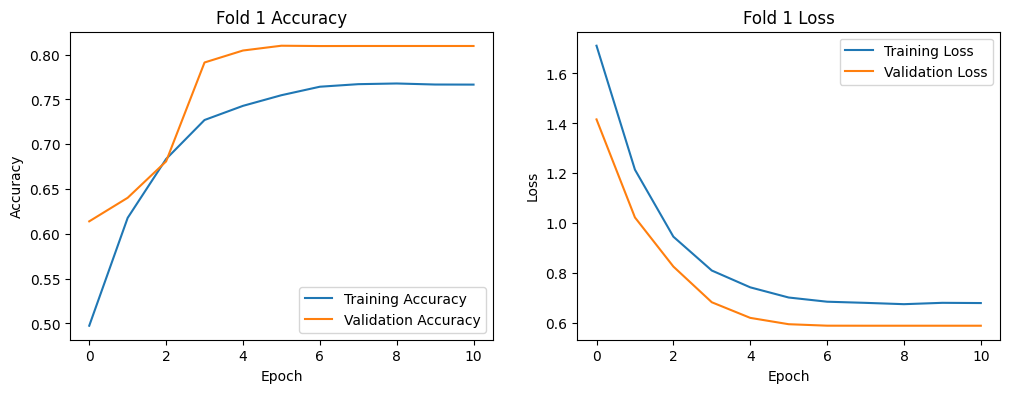

Fold 2
Epoch 1/20


c:\Users\ADVAN\machine-learning\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.4217 - loss: 1.8891 - val_accuracy: 0.6155 - val_loss: 1.5461
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.5839 - loss: 1.3347 - val_accuracy: 0.6440 - val_loss: 1.0827
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.6575 - loss: 1.0040 - val_accuracy: 0.6740 - val_loss: 0.8134
Epoch 4/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.7096 - loss: 0.8275 - val_accuracy: 0.7398 - val_loss: 0.6938
Epoch 5/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.7434 - loss: 0.7325 - val_accuracy: 0.8233 - val_loss: 0.6277
Epoch 6/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.7722 - loss: 0.6748 - val_accuracy: 0.8295 - val_loss: 0.6020
Epoch 7/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.7875 - loss: 0.6498 - val_accuracy: 0.8282 - val_loss: 0.5966
Epoch 8/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7861 - loss: 0.6455 - val_accuracy: 0.82

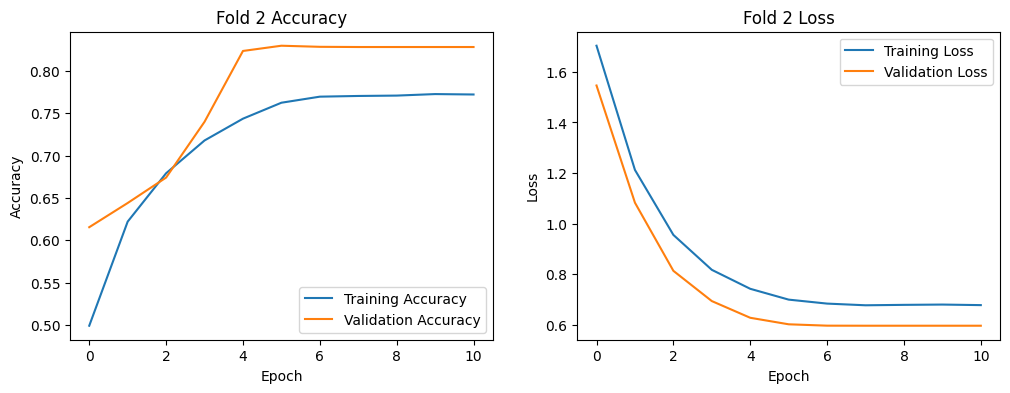

Fold 3
Epoch 1/20


c:\Users\ADVAN\machine-learning\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


133/133 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.4742 - loss: 1.8593 - val_accuracy: 0.5475 - val_loss: 1.4139
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.6337 - loss: 1.2498 - val_accuracy: 0.5990 - val_loss: 1.0941
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.7000 - loss: 0.9571 - val_accuracy: 0.6234 - val_loss: 0.9297
Epoch 4/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.7417 - loss: 0.8128 - val_accuracy: 0.6726 - val_loss: 0.7836
Epoch 5/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7717 - loss: 0.7235 - val_accuracy: 0.7550 - val_loss: 0.6832
Epoch 6/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7935 - loss: 0.6660 - val_accuracy: 0.8146 - val_loss: 0.6377
Epoch 7/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.8057 - loss: 0.6385 - val_accuracy: 0.8342 - val_loss: 0.6242
Epoch 8/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.8112 - loss: 0.6299 - val_accuracy: 0.83

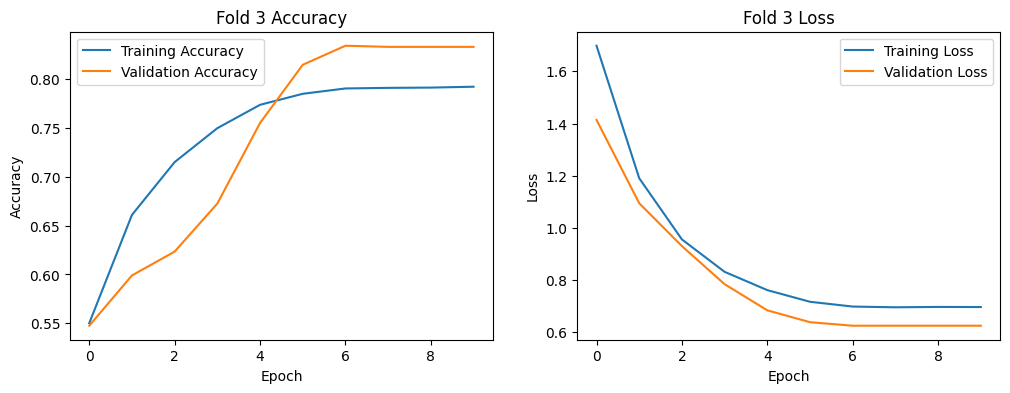

Fold 4
Epoch 1/20


c:\Users\ADVAN\machine-learning\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.4535 - loss: 1.9067 - val_accuracy: 0.5279 - val_loss: 1.6048
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.5768 - loss: 1.4197 - val_accuracy: 0.6149 - val_loss: 1.1534
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.7039 - loss: 1.0325 - val_accuracy: 0.7203 - val_loss: 0.9113
Epoch 4/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.7716 - loss: 0.8438 - val_accuracy: 0.8095 - val_loss: 0.7446
Epoch 5/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8027 - loss: 0.7455 - val_accuracy: 0.8420 - val_loss: 0.6681
Epoch 6/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.8130 - loss: 0.6974 - val_accuracy: 0.8521 - val_loss: 0.6415
Epoch 7/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.8216 - loss: 0.6736 - val_accuracy: 0.8556 - val_loss: 0.6340
Epoch 8/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.8217 - loss: 0.6709 - val_accuracy: 0.85

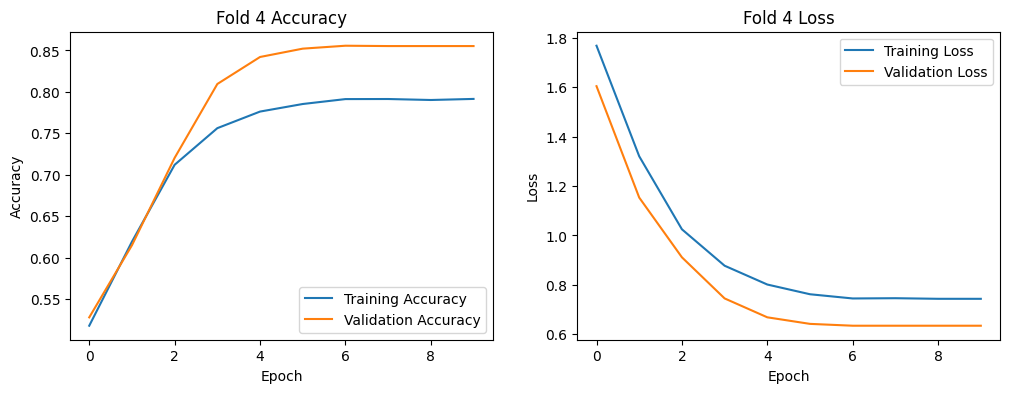

Fold 5
Epoch 1/20


c:\Users\ADVAN\machine-learning\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


133/133 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.4396 - loss: 1.9041 - val_accuracy: 0.5223 - val_loss: 1.6011
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.5672 - loss: 1.4218 - val_accuracy: 0.5969 - val_loss: 1.1557
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.6383 - loss: 1.0953 - val_accuracy: 0.6476 - val_loss: 0.9291
Epoch 4/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.6764 - loss: 0.9191 - val_accuracy: 0.6923 - val_loss: 0.7888
Epoch 5/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7055 - loss: 0.8156 - val_accuracy: 0.7466 - val_loss: 0.7136
Epoch 6/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7368 - loss: 0.7591 - val_accuracy: 0.8182 - val_loss: 0.6808
Epoch 7/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.7538 - loss: 0.7299 - val_accuracy: 0.8389 - val_loss: 0.6727
Epoch 8/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.7621 - loss: 0.7255 - val_accuracy: 0.83

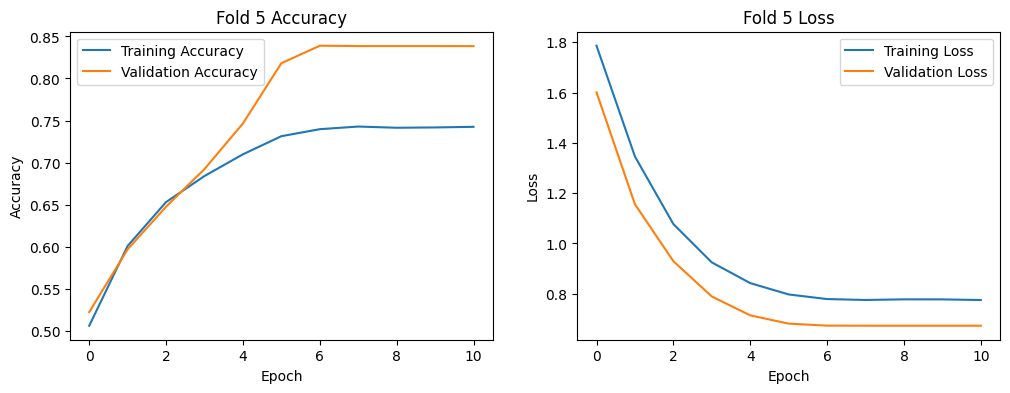

Average Weighted F1-score: 0.8301701135421006


In [129]:
# 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(padded_sequences, labels)):
    print(f'Fold {fold + 1}')
    X_train, X_val = padded_sequences[train_idx], padded_sequences[val_idx]
    y_train, y_val = labels[train_idx], labels[val_idx]
    y_train_cat = to_categorical(y_train, num_classes=3)
    y_val_cat = to_categorical(y_val, num_classes=3)

    # Create tf.data.Dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_cat)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val_cat)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Model
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length, trainable=True),
        Bidirectional(LSTM(16, return_sequences=True, dropout=0.5, kernel_regularizer=l2(5e-3))),
        SimpleAttention(),
        Dense(16, activation='relu', kernel_regularizer=l2(5e-3)),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])

    # Focal loss (graph-compatible)
    def focal_loss(gamma=2.0, alpha=None):
        if alpha is None:
            alpha = tf.constant([2.5, 2.5, 2.0], dtype=tf.float32)
        def focal_loss_fn(y_true, y_pred):
            y_true = tf.cast(y_true, tf.float32)
            y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())
            cross_entropy = -y_true * tf.math.log(y_pred)
            alpha_t = tf.gather(alpha, tf.argmax(y_true, axis=-1))
            alpha_t = tf.expand_dims(alpha_t, -1)
            focal_weight = alpha_t * tf.math.pow(1 - y_pred, gamma)
            loss = focal_weight * cross_entropy
            return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))
        return focal_loss_fn

    # Compile model
    initial_learning_rate = 3e-4
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate, decay_steps=1000, alpha=1e-5)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss=focal_loss(gamma=2.0), optimizer=optimizer, metrics=['accuracy'])

    # Class weights
    class_weights = compute_class_weight('balanced', classes=np.array([0, 1, 2]), y=y_train)
    class_weights = dict(enumerate(class_weights))

    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, min_delta=5e-5, restore_best_weights=True),
        ModelCheckpoint(f'model/lstm/lstm_model_fold{fold+1}.keras', monitor='val_loss', save_best_only=True)
    ]

    # Train model
    history = model.fit(
        train_dataset, epochs=20, validation_data=val_dataset, callbacks=callbacks,
        class_weight=class_weights, verbose=1
    )

    # Evaluate
    val_pred = model.predict(X_val)
    val_pred_classes = np.argmax(val_pred, axis=1)
    f1 = classification_report(y_val, val_pred_classes, target_names=['Hate', 'Offensive', 'Neither'], output_dict=True)['weighted avg']['f1-score']
    f1_scores.append(f1)
    print(f"Fold {fold + 1} Weighted F1-score: {f1}")

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {fold + 1} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold + 1} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

print(f'Average Weighted F1-score: {np.mean(f1_scores)}')

In [132]:
print(df_balanced.groupby('label').size())


label
0    30003
1    25000
2    29993
dtype: int64


In [136]:
tf.config.run_functions_eagerly(True)

# Buat ulang optimizer sebelum compile model (ganti dengan optimizer yang kamu pakai)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Split data dan one-hot encoding label
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, 
    to_categorical(labels, num_classes=3), 
    test_size=0.15, 
    random_state=42, 
    stratify=labels
)

# Definisikan model
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length, trainable=True),
    Bidirectional(LSTM(16, return_sequences=True, dropout=0.5, kernel_regularizer=l2(5e-3))),
    SimpleAttention(),
    Dense(16, activation='relu', kernel_regularizer=l2(5e-3)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile model dengan optimizer baru
model.compile(loss=focal_loss(gamma=2.0), optimizer=optimizer, metrics=['accuracy'])

# Hitung class weights dari label asli (argmax karena y_train sudah one-hot)
class_weights_values = compute_class_weight('balanced', classes=np.array([0, 1, 2]), y=np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights_values))

# Training model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=batch_size,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/20


c:\Users\ADVAN\machine-learning\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
c:\Users\ADVAN\machine-learning\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


142/142 ━━━━━━━━━━━━━━━━━━━━ 51s 357ms/step - accuracy: 0.5328 - loss: 1.5100 - val_accuracy: 0.8259 - val_loss: 0.5890
Epoch 2/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 65s 459ms/step - accuracy: 0.7912 - loss: 0.5852 - val_accuracy: 0.8848 - val_loss: 0.3831
Epoch 3/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 64s 448ms/step - accuracy: 0.8664 - loss: 0.4222 - val_accuracy: 0.9003 - val_loss: 0.3210
Epoch 4/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 71s 502ms/step - accuracy: 0.8844 - loss: 0.3549 - val_accuracy: 0.9121 - val_loss: 0.2897
Epoch 5/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 58s 408ms/step - accuracy: 0.8991 - loss: 0.3085 - val_accuracy: 0.9192 - val_loss: 0.2738
Epoch 6/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 55s 385ms/step - accuracy: 0.9079 - loss: 0.2725 - val_accuracy: 0.9236 - val_loss: 0.2568
Epoch 7/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 52s 364ms/step - accuracy: 0.9142 - loss: 0.2517 - val_accuracy: 0.9198 - val_loss: 0.2606
Epoch 8/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 50s 353ms/step - accuracy: 0.9174 - loss: 0.2398 - val

In [137]:
# Evaluate on test set
test_pred = model.predict(X_test)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true_classes = np.argmax(y_test, axis=1)
print("\nClassification Report (Test - LSTM):\n")
print(classification_report(test_true_classes, test_pred_classes, target_names=['Hate', 'Offensive', 'Neither']))

399/399 ━━━━━━━━━━━━━━━━━━━━ 48s 120ms/step

Classification Report (Test - LSTM):

              precision    recall  f1-score   support

        Hate       0.93      0.92      0.93      4501
   Offensive       0.95      0.91      0.93      3750
     Neither       0.91      0.96      0.94      4499

    accuracy                           0.93     12750
   macro avg       0.93      0.93      0.93     12750
weighted avg       0.93      0.93      0.93     12750



In [138]:
# Create tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Visualizations

<Figure size 600x600 with 0 Axes>

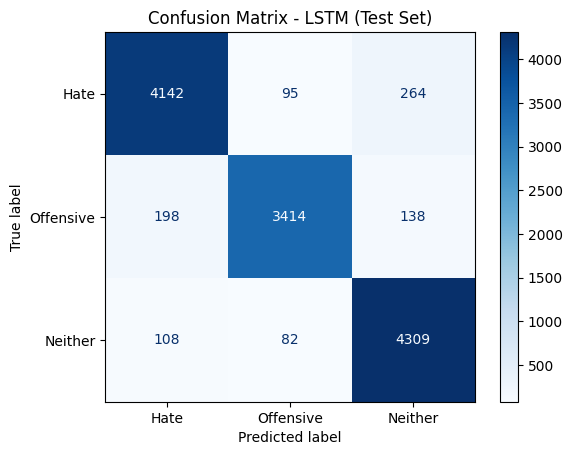

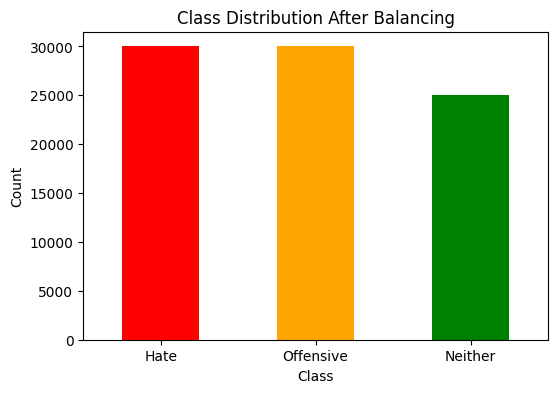

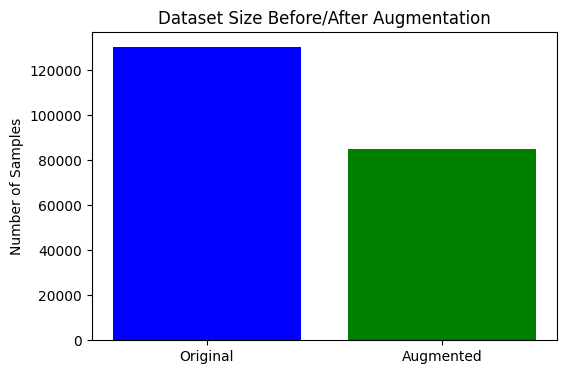

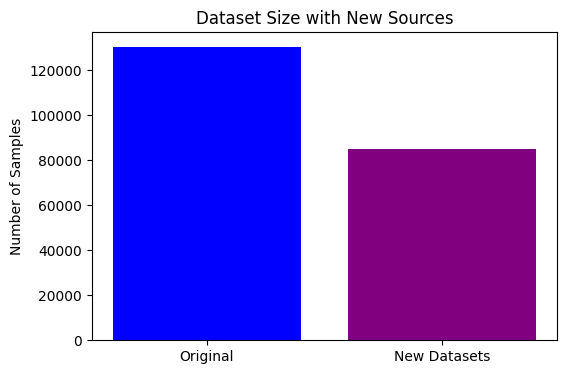

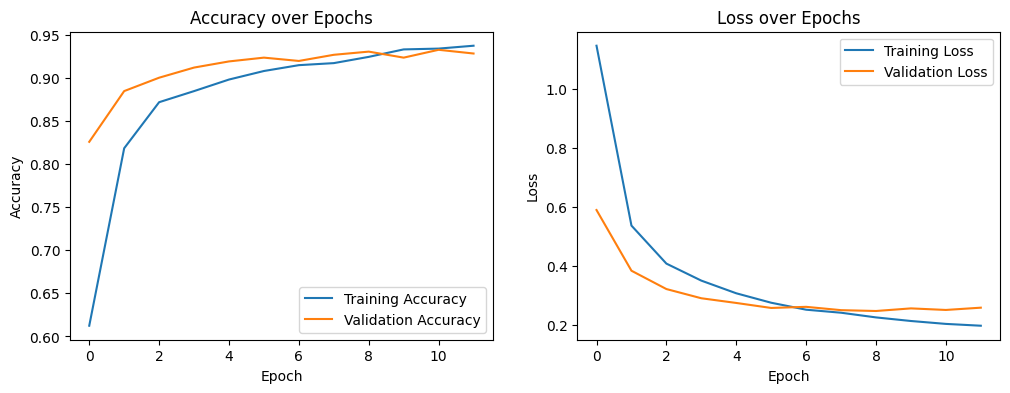

In [ ]:
# Confusion Matrix
cm = confusion_matrix(test_true_classes, test_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Hate', 'Offensive', 'Neither'])
plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - LSTM (Test Set)')
plt.show()

# Class Distribution
plt.figure(figsize=(6, 4))
df_balanced['label'].value_counts().plot(kind='bar', color=['red', 'orange', 'green'])
plt.title('Class Distribution After Balancing')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Hate', 'Offensive', 'Neither'], rotation=0)
plt.show()

# Augmentation Impact
plt.figure(figsize=(6, 4))
plt.bar(['Original', 'Augmented'], [len(df), len(df_balanced)], color=['blue', 'green'])
plt.title('Dataset Size Before/After Augmentation')
plt.ylabel('Number of Samples')
plt.show()

# Dataset Overlap
plt.figure(figsize=(6, 4))
plt.bar(['Original', 'New Datasets'], [len(df), len(df_balanced)], color=['blue', 'purple'])
plt.title('Dataset Size with New Sources')
plt.ylabel('Number of Samples')
plt.show()

# Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [140]:
# Test inference-like inputs
inference_tests = [
    ("omg beautiful", 2), ("amazing", 2), ("holy", 2), ("omg", 2), ("bastard", 1),
    ("hello guys im here", 2), ("great bro", 2), ("nigger", 0), ("youre a pathetic loser", 1),
    ("lets go", 2), ("are you serious", 2), ("wtf", 2), ("lets fuckin go", 2),
    ("omg how this grok so idiot", 1), ("not bad", 2), ("well done", 2),
    ("had a long day need a nap", 2), ("this is fuckin awesome", 2),
    ("yo this game is dope sunglasses", 2), ("what a bitch always complaining", 1),
    ("this app is a ripoff pure garbage", 1), ("muslims are terrorists ban them all", 0),
    ("black people are just lazy leeches", 0), ("beautiful weather for a walk today", 2),
    ("i love you", 2), ("i mean thats alright", 2), ("just stop doing that", 2),
    ("why are you doing that", 2), ("why you are so dumb", 1), ("dawg do you even had a brain", 1),
    ("indian nigga", 0), ("indian jerk bastard", 1), ("stfu indian", 0),
    ("fr this game slaps bet", 2), ("vibin with the fam yo", 2)
]
print("\nInference-like Test Results:")
test_texts = []
for text, _ in inference_tests:
    cleaned = clean_text(text)
    test_texts.append(cleaned)
    print(f"Raw: {text} -> Cleaned: {cleaned}")
test_sequences = tokenizer.texts_to_sequences(test_texts)
test_padded = np.clip(pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post'), 0, vocab_size - 1)
test_preds = model.predict(test_padded)
test_pred_classes = np.argmax(test_preds, axis=1)
for (text, true_label), pred_class, probs, cleaned in zip(inference_tests, test_pred_classes, test_preds, test_texts):
    class_names = ['Hate', 'Offensive', 'Neither']
    print(f"Input: {text} (Cleaned: {cleaned})")
    print(f"True Class: {class_names[true_label]}")
    print(f"Predicted Class: {class_names[pred_class]}, Confidence: {probs[pred_class]:.4f}")
    print(f"Scores: Hate={probs[0]:.4f}, Offensive={probs[1]:.4f}, Neither={probs[2]:.4f}\n")


Inference-like Test Results:
Raw: omg beautiful -> Cleaned: oh my god beautiful
Raw: amazing -> Cleaned: amazing
Raw: holy -> Cleaned: holy
Raw: omg -> Cleaned: oh my god
Raw: bastard -> Cleaned: bastard
Raw: hello guys im here -> Cleaned: hello guys im here
Raw: great bro -> Cleaned: great bro
Raw: nigger -> Cleaned: nigger
Raw: youre a pathetic loser -> Cleaned: youre a pathetic loser
Raw: lets go -> Cleaned: lets go
Raw: are you serious -> Cleaned: are you serious
Raw: wtf -> Cleaned: what the fuck
Raw: lets fuckin go -> Cleaned: lets fuckin go
Raw: omg how this grok so idiot -> Cleaned: oh my god how this grok so idiot
Raw: not bad -> Cleaned: not bad
Raw: well done -> Cleaned: well done
Raw: had a long day need a nap -> Cleaned: had a long day need a nap
Raw: this is fuckin awesome -> Cleaned: this is fuckin awesome
Raw: yo this game is dope sunglasses -> Cleaned: hey this game is great sunglasses
Raw: what a bitch always complaining -> Cleaned: what a bitch always complaining
Ra

c:\Users\ADVAN\machine-learning\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Input: omg beautiful (Cleaned: oh my god beautiful)
True Class: Neither
Predicted Class: Hate, Confidence: 0.5894
Scores: Hate=0.5894, Offensive=0.2517, Neither=0.1589

Input: amazing (Cleaned: amazing)
True Class: Neither
Predicted Class: Neither, Confidence: 0.4911
Scores: Hate=0.2637, Offensive=0.2452, Neither=0.4911

Input: holy (Cleaned: holy)
True Class: Neither
Predicted Class: Neither, Confidence: 0.8290
Scores: Hate=0.1249, Offensive=0.0461, Neither=0.8290

Input: omg (Cleaned: oh my god)
True Class: Neither
Predicted Class: Neither, Confidence: 0.5303
Scores: Hate=0.3465, Offensive=0.1232, Neither=0.5303

Input: bastard (Cleaned: bastard)
True Class: Offensive
Predicted Class: Neither, Confidence: 0.6199
Scores: Hate=0.2705, Offensive=0.1097, Neither=0.6199

Input: hello guys im here (Cleaned: hello guys im here)
True Class: Neither
Predicted Class: Neither, Confidence: 0.6909
Scores: Hate=0.2248, Offensive=0.0843, Neither=0.6909

Input:

In [141]:
correct = sum(p == t for p, (_, t) in zip(test_pred_classes, inference_tests))
accuracy = correct / len(inference_tests)
print(f"Accuracy: {accuracy:.2%}")


Accuracy: 68.57%


In [142]:
# Save model
os.makedirs('model/lstm/', exist_ok=True)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()
with open('model/lstm/tflite_model.tflite', 'wb') as f:
    f.write(tflite_model)
model.save('model/lstm/lstm_model.keras')
with open('model/lstm/tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: C:\Users\ADVAN\AppData\Local\Temp\tmp4eo5yyvc\assets


INFO:tensorflow:Assets written to: C:\Users\ADVAN\AppData\Local\Temp\tmp4eo5yyvc\assets


Saved artifact at 'C:\Users\ADVAN\AppData\Local\Temp\tmp4eo5yyvc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(512, 30), dtype=tf.float32, name='keras_tensor_98')
Output Type:
  TensorSpec(shape=(512, 3), dtype=tf.float32, name=None)
Captures:
  2413543607568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2411833056848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2413543609488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2413543616400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2413543609872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2411833064336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2413543611984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2413543610448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2413543606800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2413543617936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2413543610832